# Analisis de base de datos de fútbol

In [1]:
#importar packages
import sqlite3
import pandas as pd
import sqlalchemy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  



engine=sqlalchemy.create_engine(r'sqlite:///C:\Users\56945\Downloads\database.sqlite')

## 1) Toda la información para cada partido

Con la siguiente query, se puede obtener toda la información disponible para cada partido

In [2]:
match=pd.read_sql(
    """ 
    SELECT  a.*, b.name as country_name, c.name as league_name, d_h.team_long_name as home_team_name, d_a.team_long_name as away_team_name
    FROM Match as a
    LEFT JOIN Country as b on a.country_id=b.id
    LEFT JOIN League as c on a.league_id=c.id
    LEFT JOIN Team as d_h on a.home_team_api_id=d_h.team_api_id 
    LEFT JOIN Team as d_a on a.away_team_api_id=d_a.team_api_id 
    """
    , engine
)

In [3]:
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,GBH,GBD,GBA,BSH,BSD,BSA,country_name,league_name,home_team_name,away_team_name
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,1.78,3.25,4.00,1.73,3.40,4.20,Belgium,Belgium Jupiler League,KRC Genk,Beerschot AC
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,1.85,3.25,3.75,1.91,3.25,3.60,Belgium,Belgium Jupiler League,SV Zulte-Waregem,Sporting Lokeren
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,3.20,2.50,2.30,3.20,2.75,Belgium,Belgium Jupiler League,KSV Cercle Brugge,RSC Anderlecht
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,1.50,3.75,5.50,1.44,3.75,6.50,Belgium,Belgium Jupiler League,KAA Gent,RAEC Mons
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,4.50,3.50,1.65,4.75,3.30,1.67,Belgium,Belgium Jupiler League,FCV Dender EH,Standard de Liège


Se observa que el dataframe llamado "matches", está compuesto por 26979 partidos unicos y 119 filas distintas

## 2) Insights la información detallada de cada partido
Para poder realizar la busqueda de insights, se procede a limpiar el dataframe matches, esto con el objetivo de disminuir las 119 filas y dejar las que pueden ser más utiles para el análisis

In [4]:
matches=match[['id','country_name','league_name','season','date','home_team_name','home_team_goal','away_team_name','away_team_goal']]
matches['winner']= np.where( matches['home_team_goal']>matches['away_team_goal'],'home',
                np.where(matches['home_team_goal']==matches['away_team_goal'],'tie',
                np.where(matches['away_team_goal']>matches['home_team_goal'],'away','error')))
matches['total_goals']=matches['home_team_goal']+matches['away_team_goal']




### 1. Locales vs Visitantes
Se observa que del total de partidos, los equipos que jugaron de local ganaron casi la mitad de todos los encuentros:
* Locales: 46%
* Visitantes: 29%
* Empates: 25%

In [5]:
matches.groupby(by="winner")['id'].count()

winner
away     7466
home    11917
tie      6596
Name: id, dtype: int64

### 2. Goles por equipo y temporada
Como se puede observar en la figura de a continuación, las temporadas tienen similares numeros de goles, pero se puede resumir de la siguiente manera:
* Más goles: 2015/2016 con 9162 goles
* Menos goles: 2013/2014 con 8389 goles

In [6]:
matches.groupby('season')[['home_team_goal','away_team_goal','total_goals']].sum()

,home_team_goal,away_team_goal,total_goals
season,,,
2008/2009,5007,3665,8672
2009/2010,4978,3654,8632
2010/2011,5048,3701,8749
2011/2012,5064,3683,8747
2012/2013,5053,3986,9039
2013/2014,4787,3602,8389
2014/2015,5055,3842,8897
2015/2016,5135,4027,9162


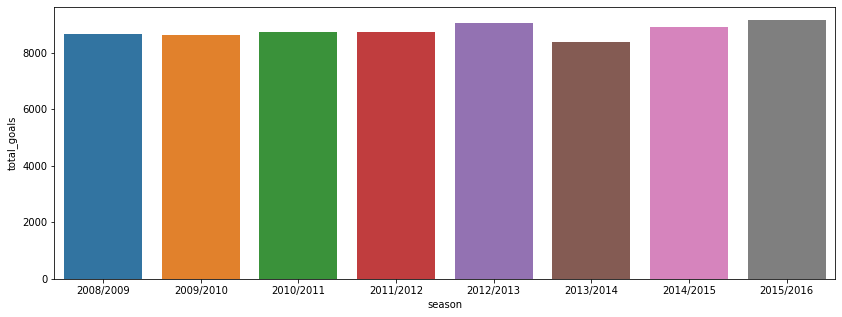

In [7]:
plt.figure(figsize=(14, 5))
sns.barplot(y='total_goals',x='season',data=matches, estimator=sum, ci=None)
plt.show()

### 3. Home or away?
Se procede a crear un calculo para saber que tan bien juegan los equipos de local.


Primero se observa a los 5 mejores equipos que juegan de local

In [8]:
matches['winner_home']=np.where(matches['winner']=='home', 1, 0)
print(matches.groupby('home_team_name')['winner_home'].mean().sort_values( ascending=False).head())

home_team_name
FC Barcelona        0.861842
Real Madrid CF      0.848684
SL Benfica          0.822581
FC Porto            0.822581
FC Bayern Munich    0.801471
Name: winner_home, dtype: float64


Ahora, se presentan a los 5 peores equipos que jugan de local

In [9]:
matches.groupby('home_team_name')['winner_home'].mean().sort_values().head()

home_team_name
SpVgg Greuther Fürth    0.000000
Córdoba CF              0.052632
Dunfermline Athletic    0.052632
AC Arles-Avignon        0.105263
SV Darmstadt 98         0.117647
Name: winner_home, dtype: float64

### 4. Partidos por año
Como se puede apreciar, todos los años se tiene una cantidad similar de partidos jugados, pero la temporada 2013/2014 tuvo una caída notoria.

Se puede extrapolar que para el punto 2, donde se ven los goles por season, la temporada con menos goles es también la que posee una cantidad inferior de partidos

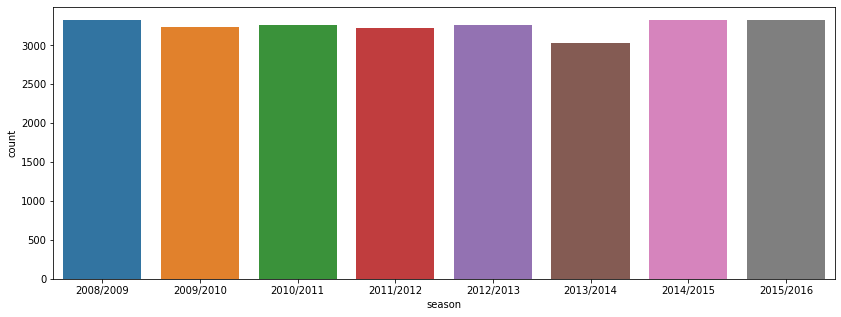

In [10]:
plt.figure(figsize=(14, 5))
sns.countplot(x='season',data=matches)
plt.show()

## 3) Información detallada por jugador (uno por fila)

A continuación se entrega la mejor versión de cada jugador junto con sus respectivos atributos.


In [11]:
players=pd.read_sql(
    """ 
    SELECT a.*, b.player_name, b.height
    FROM(
        SELECT *, row_number()OVER(PARTITION BY player_api_id ORDER BY overall_rating DESC) as ranked
        from Player_Attributes) as a
    LEFT JOIN Player as b on b.player_api_id=a.player_api_id
    WHERE ranked=1
    """
    , engine
)


In [12]:
players.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,ranked,player_name,height
0,139856,148544,2625,2007-08-30 00:00:00,63,64,right,high,medium,48,...,66,63.0,14,24,67,24,24,1,"Patryk Rachwal,18",175.26
1,44145,135819,2752,2015-10-16 00:00:00,72,72,right,medium,medium,39,...,74,67.0,12,7,8,10,16,1,Diego Mainz,187.96
2,88286,110019,2768,2016-03-03 00:00:00,75,75,left,medium,medium,44,...,77,79.0,12,15,13,14,10,1,Jose Dorado,180.34
3,72150,182861,2770,2011-02-22 00:00:00,74,81,left,medium,low,63,...,48,25.0,12,13,6,14,15,1,Ignacio Gonzalez,180.34
4,5123,110809,2790,2009-08-30 00:00:00,73,77,left,None,7,78,...,78,69.0,8,21,73,21,21,1,Alberto Rey,175.26


### 4) Mejor equipo de la historia + Bonus

 Para buscar al mejor equipo posible se realizó una investigación para obtener los atributos mas importantes para cada puesto en el campo (defensa, mediocampo y delanteros) y posteriormente se procede a realizar un promedio ponderado, este es asignando según la importancia para el puesto a jugar. Mientras que para los porteros, se obtiene el promedio de los atributos especiales para los goalkeepers

In [ ]:

df=pd.read_sql(
    """
    WITH best_season as (  
    SELECT a.*, b.player_name, b.height
    FROM(
        SELECT *, row_number()OVER(PARTITION BY player_api_id ORDER BY overall_rating DESC) as ranked
        from Player_Attributes) as a
    LEFT JOIN Player as b on b.player_api_id=a.player_api_id
    WHERE ranked=1)
	
SELECT player_name, 
(0.1*acceleration+ 0.1*stamina+0.15*strength+0.05*standing_tackle+0.05*sliding_tackle+0.15*heading_accuracy+0.05*short_passing+0.05*long_passing+0.1*aggression+0.1*interceptions+0.1*marking)as rating_defenders,
(0*09*stamina+0.09*agility+0.09*ball_control+0.05*acceleration+0.09*short_passing+0.09*long_passing+0.05*strength+0.05*dribbling+0.09*interceptions+0.09*sprint_speed+0.05*marking+0.05*jumping+0.12*vision) as rating_midfielders,
(0.1*sprint_speed+0.05*acceleration+0.1*reactions+0.09*jumping+0.1*ball_control+0.1*heading_accuracy+0.05*positioning+0.1*penalties+0.15*shot_power+0.05*agility+0.05*strength+0.03*short_passing+0.03*long_passing) as rating_forwards,
(gk_diving+gk_handling+gk_kicking+gk_positioning+gk_reflexes)/5 as rating_goalkeepers
FROM best_season
    """
    ,engine)

Según variados medios especialzidos en fútbol, la formación 2-4-4 existen 2 defensas, 4 mediocampistas y 4 delanteros, es una alineación que permite estar concentrado en el ataque al oponente.

Entonces, se proceden a calcular los mejores jugadores para poder tener nuestro equipo perfecto

In [ ]:
arquero=df.sort_values('rating_goalkeepers', ascending=False).iloc[:1]
arquero['posicion']='arquero'

defensas=df.sort_values('rating_defenders', ascending=False).iloc[:2]
defensas['posicion']='defensa'

mediocampistas=df.sort_values('rating_midfielders', ascending=False).iloc[:4]
mediocampistas['posicion']='mediocampo'

delanteros=df.sort_values('rating_forwards', ascending=False).iloc[:4]
delanteros['posicion']='delantero'


mejor_equipo_historico=pd.concat([arquero,defensas,mediocampistas,delanteros])
print(mejor_equipo_historico[['player_name','posicion']])

            player_name    posicion
3795     Gregory Coupet     arquero
1849       Carles Puyol     defensa
2692     Patrick Vieira     defensa
1857     Michael Essien  mediocampo
1887    Francesco Totti  mediocampo
1834      Frank Lampard  mediocampo
2565       Daniel Alves  mediocampo
1979  Cristiano Ronaldo   delantero
1953    Fernando Torres   delantero
1931      Didier Drogba   delantero
2441       Samuel Eto'o   delantero


### Bonus: Peor equipo de la historia

Algo a tener en cuenta es que las posiciones asignadas no son las que pertenecen al jugador, si no que serían las posiciones donde ese juagador es el menos cualificado. Por ejemplo, Darian MacKinnon no es arquero, pero posee las habilidades de goalkeeper más bajas de todos los jugadores dentro del dataset.

Por lo tanto, este sería literalmente el peor equipo de la historia!

In [ ]:
arquero=df.sort_values('rating_goalkeepers').iloc[:1]
arquero['posicion']='arquero'

defensas=df.sort_values('rating_defenders').iloc[:2]
defensas['posicion']='defensa'

mediocampistas=df.sort_values('rating_midfielders').iloc[:5]
mediocampistas['posicion']='mediocampo'

delanteros=df.sort_values('rating_forwards').iloc[:3]
delanteros['posicion']='delantero'


peor_equipo_historico=pd.concat([arquero,defensas,mediocampistas,delanteros])
print(peor_equipo_historico[['player_name','posicion']])

            player_name    posicion
9619   Darian MacKinnon     arquero
9189            Rodrigo     defensa
3887       Kevin Olimpa     defensa
9175      Marc McCallum  mediocampo
8761    Dziugas Bartkus  mediocampo
7004       Ibrahim Kone  mediocampo
8493      Connor Ripley  mediocampo
10546      Aaron Lennox  mediocampo
183        Dusan Pernis   delantero
6907    Bruno Verissimo   delantero
5370      Florian Bague   delantero
